In [1]:
import os
import time
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from utils import show_image
from detection import inference, inference_url, get_image, get_detections
from matplotlib.patches import Rectangle

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from object_detection.utils import label_map_util

In [4]:
%matplotlib inline

Initialize bg subtraction object

In [5]:
fgbg_1 = cv2.createBackgroundSubtractorMOG2(detectShadows=False, history=50, varThreshold=16)
fgbg_2 = cv2.createBackgroundSubtractorMOG2(detectShadows=False, history=50, varThreshold=8)
fgbg_3 = cv2.createBackgroundSubtractorKNN(detectShadows=False, history=50)

In [ ]:
fg = [[], [], []]
bg = None
cnt = 0

Test on a stream

TODO: https://www.vegvesen.no/trafikkinformasjon/reiseinformasjon/Trafikkmeldinger/Webkamera#/vis/751511/video

In [16]:
STREAM = 'https://kamera.vegvesen.no/public/0229004_1/hls_1_stream_1_orig.m3u8'

In [17]:
vstream = None
try:
    print("Started Video Stream")
    vstream = cv2.VideoCapture(STREAM)
    while True:
        ret, frame = vstream.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)            
            frame = frame[120:, 0:550, :] # Region Cropping.
            bg = frame.copy()
            fg[0].append(fgbg_1.apply(frame.copy()))
            fg[1].append(fgbg_2.apply(frame.copy()))
            fg[2].append(fgbg_3.apply(frame.copy()))
            cnt += 1
            print('Processed Frame', cnt)
        time.sleep(0.25)
except:
    print("Stopped Video Stream")
finally:
    vstream.release()

Started Video Stream
Processed Frame 244
Processed Frame 245
Processed Frame 246
Processed Frame 247
Processed Frame 248
Processed Frame 249
Processed Frame 250
Processed Frame 251
Processed Frame 252
Processed Frame 253
Processed Frame 254
Processed Frame 255
Processed Frame 256
Processed Frame 257
Processed Frame 258
Processed Frame 259
Processed Frame 260
Processed Frame 261
Processed Frame 262
Processed Frame 263
Processed Frame 264
Processed Frame 265
Processed Frame 266
Processed Frame 267
Processed Frame 268
Processed Frame 269
Processed Frame 270
Processed Frame 271
Processed Frame 272
Processed Frame 273
Processed Frame 274
Processed Frame 275
Processed Frame 276
Processed Frame 277
Processed Frame 278
Processed Frame 279
Processed Frame 280
Processed Frame 281
Processed Frame 282
Processed Frame 283
Processed Frame 284
Processed Frame 285
Processed Frame 286
Processed Frame 287
Processed Frame 288
Processed Frame 289
Processed Frame 290
Processed Frame 291
Processed Frame 292

In [18]:
# Override ...
#bg = cv2.imread('../images/temp/bgsub.png', cv2.IMREAD_COLOR)
#fg = [[None], [None], [None]]
#fg[-1][-1] = cv2.imread('../images/temp/knn.png', cv2.IMREAD_GRAYSCALE)

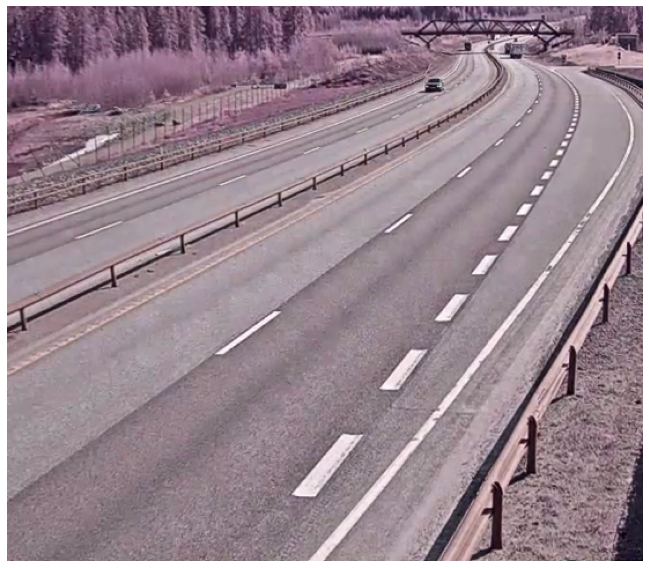

In [19]:
show_image(bg)

Extract objects

In [20]:
def blur(src, size):
    return cv2.blur(src, size)

def box_blur(src, size, normalize=False):
    return cv2.boxFilter(src, src.shape[-1], size, normalize=normalize)

def median_blur(src, value=5):
    return cv2.medianBlur(src, value)

def gaussian_blur(src, size, sigmaX=0, sigmaY=0):
    return cv2.GaussianBlur(src, size, sigmaX, sigmaY)

def bilateral_filter(src, diameter, sigmaCol, sigmaSpace):
    return cv2.bilateralFilter(src, diameter, sigmaCol, sigmaSpace)

In [21]:
def extract_foreground(src, fn=None):
    src = src.copy()
    if fn:
        src = fn(src)
    
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (6,6))
    kernel4 = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    
    dilate = cv2.morphologyEx(src, cv2.MORPH_DILATE, kernel1)
    closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel2)
    erosion = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel3)
    opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel4)
    
    return opening, (opening > 0).astype(int)

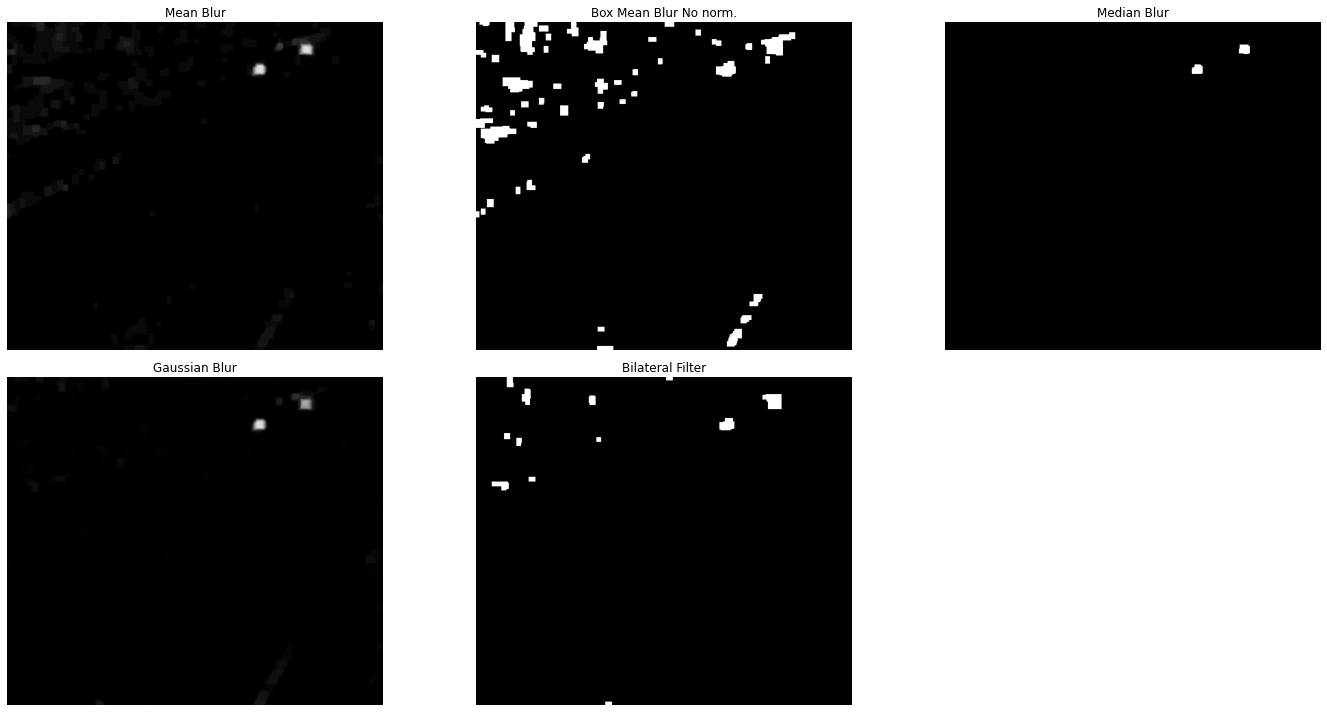

In [22]:
src = fg[-1][-1]
IMG1, _ = extract_foreground(src, fn=lambda x: blur(x, (5,5)))
IMG2, _ = extract_foreground(fg[-1][-1], fn=lambda x: box_blur(x, (5,1)))
IMG3, _ = extract_foreground(fg[-1][-1], fn=lambda x: median_blur(x,3))
IMG4, _ = extract_foreground(fg[0][-1], fn=lambda x: gaussian_blur(x, (9,9), 0))
IMG5, _ = extract_foreground(fg[-1][-1], fn=lambda x: bilateral_filter(x, 9, 50, 50))

plt.figure(figsize=(20,10))

ax = plt.subplot(231)
plt.imshow(IMG1, cmap='gray', vmin=0, vmax=255)
plt.xticks([]),plt.yticks([])
plt.title('Mean Blur')
ax.axis("off")

ax = plt.subplot(232)
plt.imshow(IMG2, cmap='gray', vmin=0, vmax=255)
plt.xticks([]),plt.yticks([])
plt.title('Box Mean Blur No norm.')
ax.axis("off")

ax = plt.subplot(233)
plt.imshow(IMG3, cmap='gray', vmin=0, vmax=255)
plt.xticks([]),plt.yticks([])
plt.title('Median Blur')
ax.axis("off")

ax = plt.subplot(234)
plt.imshow(IMG4, cmap='gray', vmin=0, vmax=255)
plt.xticks([]),plt.yticks([])
plt.title('Gaussian Blur')
ax.axis("off")

ax = plt.subplot(235)
plt.imshow(IMG5, cmap='gray', vmin=0, vmax=255)
plt.xticks([]),plt.yticks([])
plt.title('Bilateral Filter')
ax.axis("off")

plt.tight_layout()
plt.savefig('../images/temp/filtercomparison.png')
plt.show()

In [51]:
def detect_objects(bg, fg, min_size=10, thresh=0.5):
    results = []
    for v in [1, 3, 5, 7, 9]: # Try various blur values.
        I, _ = extract_foreground(fg, fn=lambda x: median_blur(x, v))
        cnt, _ = cv2.findContours(I, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(cnt) == 0:
            continue
        
        objects, reasonable_objects = [], 0
        for obj in cnt:
            obj = obj.reshape(-1,2)
            x, y = [v[0] for v in obj], [v[1] for v in obj]
            x_min, x_max = min(x), max(x)
            y_min, y_max = min(y), max(y)            
            size = min((x_max - x_min), (y_max - y_min))
            if size >= min_size:
                reasonable_objects += 1
                objects.append((
                    bg[y_min:y_max, x_min:x_max, :].copy(), 
                    Rectangle((x_min,y_min),(x_max-x_min),(y_max-y_min),linewidth=1,edgecolor='r',facecolor='none')
                ))
                
        frac = (reasonable_objects / len(cnt))
        if frac >= thresh:
            results.append((frac, objects))
        
    if len(results) == 0:
        return []
    
    results.sort(key=lambda x: x[0], reverse=True)
    return results[0][1]

def draw_bboxes(ax, objects):
    for _, rect in objects:
        ax.add_patch(rect)

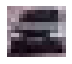

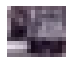

In [52]:
res = detect_objects(bg, fg[-1][-1])
for img, _ in res:
    show_image(img, size=(2,1))

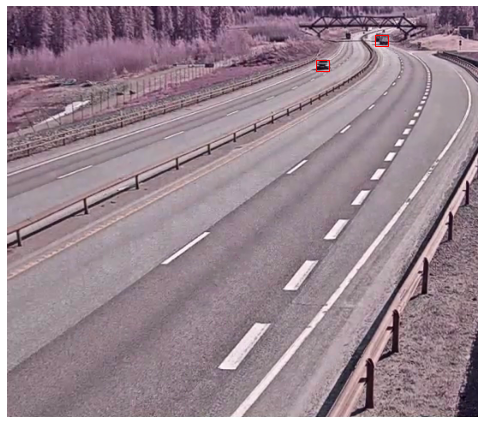

In [53]:
show_image(bg, fn=lambda ax: draw_bboxes(ax, res), size=(8,6))

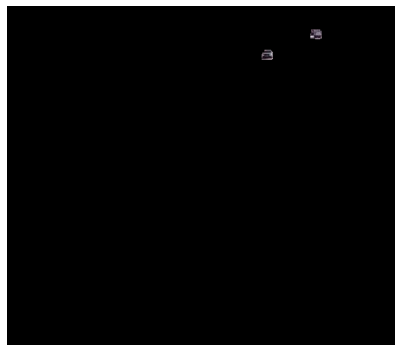

In [54]:
I, mask = extract_foreground(fg[-1][-1], fn=lambda x: median_blur(x,3))
t = bg.copy()
for i in range(3):
    t[:,:,i] = mask*t[:,:,i]
show_image(t, size=(8,5))

Load image classifier + do inference

In [33]:
LBLS = ['bike', 'bus', 'car', 'person', 'truck']

In [34]:
def predict(mdl, src, target_size=224):
    src = (cv2.resize(src, (target_size, target_size)) / 255.0) # Resize and normalize to allow prediction @ mdl.
    return LBLS[np.argmax(mdl(np.expand_dims(src, axis=0), training=False))]

In [35]:
model = tf.keras.models.load_model('../exported-models/mobilenet_fast_acc')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4226432   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,232,837
Trainable params: 4,208,437
Non-trainable params: 24,400
_________________________________________________________________


Does our R-CNN based model agree?

In [43]:
print("Loading model...")
start_time = time.time()
detect_fn = tf.saved_model.load('../exported-models/ssd_mobilenet_v2/saved_model')
print('Loading took {} seconds.'.format(time.time()-start_time))

Loading model...
Loading took 56.44222831726074 seconds.


In [56]:
category_index = label_map_util.create_category_index_from_labelmap(
    '../annotations/label_map.pbtxt', 
    use_display_name=True
)

In [68]:
targetIMG = bg.copy()

In [74]:
inference(detect_fn, targetIMG, tf.convert_to_tensor(targetIMG), category_index, False, 0.7)

['car']

In [85]:
start_time = time.time()
res = detect_objects(bg, fg[-1][-1])
for img, _ in res:
    print('CNN ->', predict(model, img.copy(), 224))
    print('SSD ->', inference(detect_fn, img.copy(), tf.convert_to_tensor(img.copy()), category_index, False, 0.35))
    print('---\n')
print('Detection took: {:.04f} sec.'.format(time.time()-start_time))

CNN -> truck
SSD -> ['car']
---

CNN -> truck
SSD -> ['bus']
---

Detection took: 0.4000 sec.
